In [340]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution, shgo, dual_annealing
from scipy.integrate import quad

In [341]:
# Parameters
r = 2
n = 2*r+1

# frequencies 
# Omegas = np.arange(1, r + 1)  # Equidistant frequencies
Omegas = np.random.rand(r) * 10  # Random frequencies
# Omegas = np.array([2,5])

Omegas.sort()

In [342]:
# Function definition
def interp_matrix(xs, r, Omegas):
    return np.array([[1/np.sqrt(2)] + [func(Omegas[k] * x) for k in range(r) for func in (np.cos, np.sin)] for x in xs])

# Generate random points for xs
# random_xs = np.random.rand(2 * r + 1) * 2 * np.pi

# Generate 2pi/n-equidistant points for xs
shift = 0
equisitant_xs =  np.linspace(0, 2 * np.pi, n, endpoint=False) + shift

A = interp_matrix(equisitant_xs, r, Omegas)

A


array([[ 0.70710678,  1.        ,  0.        ,  1.        ,  0.        ],
       [ 0.70710678, -0.57497956, -0.81816778,  0.98193687, -0.18920882],
       [ 0.70710678, -0.33879702,  0.94085949,  0.92840004, -0.37158224],
       [ 0.70710678,  0.96458228, -0.26378217,  0.84132359, -0.54053179],
       [ 0.70710678, -0.77043316, -0.63752078,  0.72385327, -0.68995394]])

In [343]:
import numpy as np

def construct_Es_inv(s, Omegas):
    """
    构造块对角矩阵 E_s^{-1}，每个块为 B_i^T，其中 B_i 为旋转矩阵。
    
    参数:
    s -- 标量，旋转角度的尺度。
    Omegas -- 列表，包含 Omega_i 的值。
    
    返回:
    E_s_inv -- 构造的块对角矩阵 E_s^{-1}。
    """
    # 计算旋转矩阵 B_i^T
    num_blocks = len(Omegas) + 1  # 第一块是 1x1 矩阵 [1]，之后每个块为 2x2 矩阵
    total_size = num_blocks * 2 - 1  # 计算总大小
    
    # 初始化一个全零矩阵，大小为 total_size x total_size
    E_s_inv = np.zeros((total_size, total_size))
    
    # 设置第一块 1x1 矩阵
    E_s_inv[0, 0] = 1
    
    # 填充后续的旋转矩阵块 B_i^T
    for i, Omega_i in enumerate(Omegas):
        # 构造每个 B_i
        B_i = np.array([[np.cos(Omega_i * s), np.sin(Omega_i * s)],
                        [-np.sin(Omega_i * s), np.cos(Omega_i * s)]])
        # 将 B_i^T 填入矩阵 E_s_inv
        E_s_inv[2*i+1:2*i+3, 2*i+1:2*i+3] = B_i.T
    
    return E_s_inv


In [344]:
s = 0.5
E_s_inv = construct_Es_inv(s, Omegas)
print(E_s_inv)

[[ 1.          0.          0.          0.          0.        ]
 [ 0.         -0.06042933 -0.99817248  0.          0.        ]
 [ 0.          0.99817248 -0.06042933  0.          0.        ]
 [ 0.          0.          0.         -0.75356161 -0.65737729]
 [ 0.          0.          0.          0.65737729 -0.75356161]]


In [345]:
s = np.random.rand()
xs = np.random.rand(n) * 2 * np.pi
shift_xs = xs + s

 # 构造矩阵 A_x 和 A_{x+s1}
A_x = interp_matrix(xs, r, Omegas)
A_x_s = interp_matrix(xs + s, r, Omegas)

# 计算矩阵 A_x 和 A_{x+s1} 的逆矩阵
A_x_inv = np.linalg.inv(A_x)
A_x_s_inv = np.linalg.inv(A_x_s)

# 构造 E_s^{-1}
E_s_inv = construct_Es_inv(s, Omegas)

# 检查等式是否成立
lhs = A_x_s_inv
rhs = E_s_inv @ A_x_inv

# 比较两边的差异
np.allclose(lhs, rhs)


True

In [346]:
print(A_x)

[[ 0.70710678 -0.763952   -0.64527308  0.84079436 -0.54135463]
 [ 0.70710678  0.90000724  0.43587495  0.78366177  0.62118775]
 [ 0.70710678  0.72031185 -0.69365037  0.25442617 -0.9670922 ]
 [ 0.70710678 -0.89553356 -0.44499399  0.45056759 -0.89274232]
 [ 0.70710678 -0.79895865 -0.60138596 -0.73666695  0.67625572]]


In [347]:
print(A_x_inv)

[[-0.87310228  0.62569985  0.13552104  1.12320354  0.40289141]
 [-0.06435503  0.1141681   0.50154926 -0.47938083 -0.07198149]
 [-1.538279    0.59388768 -0.51953732  1.71708362 -0.25315497]
 [ 1.14746363  0.13044833 -0.21490481 -0.66997136 -0.39303578]
 [ 0.71889768  0.15087734 -0.24527179 -0.94364611  0.31914287]]


In [348]:
print(lhs)

[[-0.87310228  0.62569985  0.13552104  1.12320354  0.40289141]
 [ 0.45217708 -0.09036119  0.64606443 -1.02441691  0.0165366 ]
 [-1.47172679  0.59797306 -0.32260104  1.45902437 -0.2626696 ]
 [ 0.65626547  0.04114354 -0.06937255 -0.12964603 -0.49839042]
 [ 1.18439955  0.19516133 -0.31863737 -1.15000935  0.08908584]]


In [349]:
print(lhs)

[[-0.87310228  0.62569985  0.13552104  1.12320354  0.40289141]
 [ 0.45217708 -0.09036119  0.64606443 -1.02441691  0.0165366 ]
 [-1.47172679  0.59797306 -0.32260104  1.45902437 -0.2626696 ]
 [ 0.65626547  0.04114354 -0.06937255 -0.12964603 -0.49839042]
 [ 1.18439955  0.19516133 -0.31863737 -1.15000935  0.08908584]]


你希望写一个不显式构造 E_s_inv 的函数，而是直接利用其结构特性来计算 E_s_inv @ 某个矩阵。由于 E_s_inv 是一个块对角矩阵，且每个块都是旋转矩阵的转置，我们可以利用这一特性来简化计算。

In [350]:
import numpy as np

def apply_Es_inv_to_matrix(s, Omegas, M):
    """
    利用 E_s^{-1} 矩阵的块对角特性高效地计算 E_s^{-1} @ M。
    
    参数:
    s -- 标量，旋转角度的尺度。
    Omegas -- 列表，包含 Omega_i 的值。
    M -- 要与 E_s^{-1} 相乘的矩阵。
    
    返回:
    result -- 计算结果 E_s^{-1} @ M。
    """
    # 获取 M 的尺寸，假设 M 的行数是与 E_s_inv 的大小兼容的
    n_rows, n_cols = M.shape
    num_blocks = len(Omegas) + 1  # 第一块是 1x1，后续每块是 2x2
    total_size = num_blocks * 2 - 1  # 总大小
    
    # 结果矩阵初始化为 M（我们将逐块更新它）
    result = M.copy()
    
    # 处理第一个 1x1 块（直接不变），即第一行不变
    # 第一行保持原样
    result[0, :] = M[0, :]
    
    # 处理后续的 2x2 块
    for i, Omega_i in enumerate(Omegas):
        # 构造旋转矩阵 B_i
        B_i = np.array([[np.cos(Omega_i * s), np.sin(Omega_i * s)],
                        [-np.sin(Omega_i * s), np.cos(Omega_i * s)]])
        
        # 计算 B_i^T 与 M 的对应块相乘
        start_idx = 2 * i + 1  # 每个块的开始索引
        end_idx = start_idx + 2  # 每个块的结束索引
        
        # 提取 M 的当前 2xN 子矩阵
        M_block = M[start_idx:end_idx, :]
        
        # 旋转矩阵作用在 M 的对应块上
        result[start_idx:end_idx, :] = B_i.T @ M_block
    
    return result


In [351]:
s = np.random.rand()
xs = np.random.rand(n) * 2 * np.pi
shift_xs = xs + s

 # 构造矩阵 A_x 和 A_{x+s1}
A_x = interp_matrix(xs, r, Omegas)
A_x_s = interp_matrix(xs + s, r, Omegas)

# 计算矩阵 A_x 和 A_{x+s1} 的逆矩阵
A_x_inv = np.linalg.inv(A_x)
A_x_s_inv = np.linalg.inv(A_x_s)

# 构造 E_s^{-1}
E_s_inv = construct_Es_inv(s, Omegas)

# 检查等式是否成立
lhs = A_x_s_inv
rhs = apply_Es_inv_to_matrix(s, Omegas, A_x_inv)
# 比较两边的差异
np.allclose(lhs, rhs)

True

In [19]:
def mse(xs, r, Omegas, reg=1e-6):
    # Create interpolation matrix
    A = interp_matrix(xs, r, Omegas)
    regularized_matrix = A.T @ A + reg * np.eye(A.shape[1])
    return np.trace(np.linalg.inv(regularized_matrix))

def condition_number(xs, r, Omegas, cond=2):
    A = interp_matrix(xs, r, Omegas)
    return np.linalg.cond(A, cond) # 默认是 2-norm condition number

def t_x(x, r, Omegas, order=1):
    if order == 0:
        return np.array([1 / np.sqrt(2)] + [func(Omegas[k] * x) for k in range(r) for func in (np.cos, np.sin)]).reshape(-1, 1)
    elif order == 1:
        return np.array([0] + [(Omegas[k] ** order) * (-np.sin(Omegas[k] * x)) for k in range(r)] + 
                        [(Omegas[k] ** order) * np.cos(Omegas[k] * x) for k in range(r)]).reshape(-1, 1)
    elif order == 2:
        return np.array([0] + [(Omegas[k] ** order) * (-np.cos(Omegas[k] * x)) for k in range(r)] + 
                        [(Omegas[k] ** order) * (-np.sin(Omegas[k] * x)) for k in range(r)]).reshape(-1, 1)
    else:
        raise ValueError("Order must be 0, 1, or 2.")

def compute_I_d(r, Omegas, order):
    # 矩阵维度为 2*r + 1（与 t_x(x) 的输出维度相匹配）
    I_d = np.zeros((n, n))
    
    # 计算 I_d 的每个元素
    for i in range(n):
        for j in range(n):
            # 定义被积函数，积分变量为 x
            func = lambda x: (t_x(x, r, Omegas, order) @ t_x(x, r, Omegas, order).T)[i, j]
            # 在 [0, 2*pi] 上对 func(x) 进行积分
            I_d[i, j], _ = quad(func, 0, 2 * np.pi)
    
    # 除以 2*pi 进行归一化
    return I_d / (2 * np.pi)

def avr_var_h(xs, r, Omegas, reg=1e-6, order=1):
    A = interp_matrix(xs, r, Omegas)
    regularized_matrix = A.T @ A + reg * np.eye(A.shape[1])
    VAR = np.linalg.inv(regularized_matrix)
    In = compute_I_d(r, Omegas, order)
    return np.sum(VAR * In)


def variance_fhat_x(x, xs, r, Omegas, reg=1e-6):
    A = interp_matrix(xs, r, Omegas)
    regularized_matrix = A.T @ A + reg * np.eye(A.shape[1])
    VAR = np.linalg.inv(regularized_matrix)
    t0 = t_x(x, r, Omegas, order=0)
    return t0.T @ VAR @ t0

In [20]:
xs = np.random.rand(n) * 2 * np.pi
# xs = np.linspace(0, 2 * np.pi, n, endpoint=False)

In [21]:
shift = np.random.rand()
xs = xs + shift*10
print(mse(xs, r, Omegas), condition_number(xs, r, Omegas, 2), condition_number(xs, r, Omegas, 'fro'), avr_var_h(xs, r, Omegas))
print(np.linalg.norm(interp_matrix(xs, r, Omegas), 'fro')**2)


6.007274467718474 4.6573582236657165 8.6655165863854 150.3283190592427
12.500000000000002


In [22]:
random_xs = np.random.rand(2 * r + 1) * 2 * np.pi
avr_var_h(random_xs, r, Omegas)

47041.62548145063

In [23]:
# 设置变量 xs 的范围（在 [0, 2π] 范围内搜索）
# bounds = [(0, 6 * np.pi) for _ in range(2 * r + 1)]# 优化 mse
# 设置一个宽松的边界范围，如在 [-1e6, 1e6] 内搜索
bounds = [(-1e6, 1e6) for _ in range(2 * r + 1)]
x0 = np.linspace(0, 2 * np.pi, n, endpoint=False)

result_mse = differential_evolution(mse, bounds, args=(r, Omegas), strategy='best1bin', maxiter=1000)
print("Optimized mse result:", result_mse.fun)
print("Optimal xs for mse:", result_mse.x)

# 优化 condition_number
result_cond = differential_evolution(condition_number, bounds, args=(r, Omegas), strategy='best1bin', maxiter=1000)
print("Optimized condition number result:", result_cond.fun)
print("Optimal xs for condition number:", result_cond.x)

# 优化 avr_var_h
# result_avr_var = differential_evolution(avr_var_h, bounds, args=(r, Omegas), strategy='best1bin', maxiter=1000)
# print("Optimized avr_var_h result:", result_avr_var.fun)
# print("Optimal xs for avr_var_h:", result_avr_var.x)

# from scipy.optimize import minimize

# result_avr_var = minimize(avr_var_h, x0, args=(r, Omegas), method='Nelder-Mead')
# print("Optimized avr_var_h result:", result_avr_var.fun)
# print("Optimal xs for avr_var_h:", result_avr_var.x)


Optimized mse result: 2.0209689475311685
Optimal xs for mse: [ 638386.23958328  283742.25890783     661.86142488 -468863.58799144
 -126559.45685906]
Optimized condition number result: 1.2506034381465403
Optimal xs for condition number: [ 443445.89182018  188741.75565293  485452.56841689  988264.54404503
 -547865.83247346]


In [24]:
from scipy.optimize import shgo

result_avr_var = shgo(avr_var_h, bounds=bounds, args=(r, Omegas))
print("Optimized avr_var_h result:", result_avr_var.fun)
print("Optimal xs for avr_var_h:", result_avr_var.x)


Optimized avr_var_h result: 77777637.5705159
Optimal xs for avr_var_h: [ 999023.42611445  999023.42611445 -999023.42611445 -999023.42611445
  999023.42611445]


In [25]:
print(mse(result_mse.x, r, Omegas))
print(mse(result_cond.x, r, Omegas))
print(mse(result_avr_var.x, r, Omegas))

2.0209689475311685
2.0822374683547666
3000000.356387874


In [26]:
print(condition_number(result_cond.x, r, Omegas))
print(condition_number(result_mse.x, r, Omegas))
print(condition_number(result_avr_var.x, r, Omegas))

1.2506034381465403
1.1371321036664328
1.3974336226166403e+33


In [27]:
print(avr_var_h(result_avr_var.x, r, Omegas))
print(avr_var_h(result_mse.x, r, Omegas))
print(avr_var_h(result_cond.x, r, Omegas))

77777637.5705159
55.364055740787975
56.10303709551786


In [28]:
variance_fhat_x(np.random.rand(), result_mse.x, r, Omegas, reg=1e-6)


array([[1.02383092]])

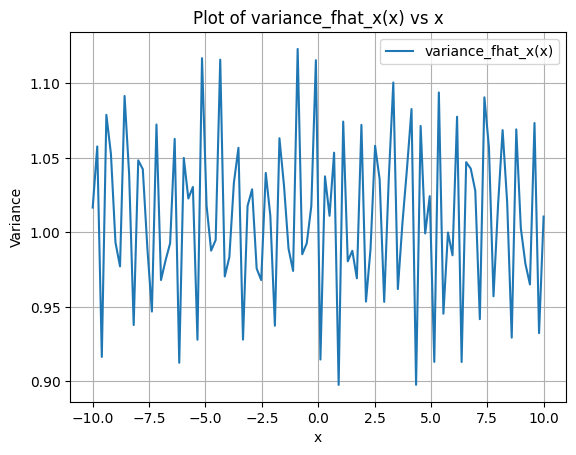

In [29]:

# 生成 x 的值
x_values = np.linspace(-10, 10, 100)  # x 的取值范围

# 计算 variance_fhat_x 对应的 y 值
y_values = [variance_fhat_x(x, result_mse.x, r, Omegas, reg=1e-6).item() for x in x_values]

# 绘图
plt.plot(x_values, y_values, label="variance_fhat_x(x)")
plt.xlabel('x')
plt.ylabel('Variance')
plt.title('Plot of variance_fhat_x(x) vs x')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
shift = np.random.rand()
xs = result_avr_var.x + shift
print(mse(xs, r, Omegas), condition_number(xs, r, Omegas), avr_var_h(xs, r, Omegas))

3000000.356468966 7.46642701462262e+32 84148208.28744917
